In [7]:
%matplotlib inline
import os
import pickle
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import theano.tensor as tt
import matplotlib.pyplot as plt
from itertools import permutations
from sklearn.mixture import GaussianMixture
import pymc3.distributions.transforms as tr

In [8]:
K = 3
ON_TRAIN = False

In [9]:
class Functions:
    def __init__(self):
        pass

    def make_cov_matrix(self, sigma=None, corr=None, chol=None, module=np):
        if chol is None:
            C = module.ones((2, 2))
            var = module.diag(sigma)
            idxu = np.triu_indices(2, 1)
            idxl = np.tril_indices(2, -1)
            if module == np:
                C[idxu] = corr
                C[idxl] = corr
            else:
                C = tt.set_subtensor(C[idxu], corr)
                C = tt.set_subtensor(C[idxl], corr)
            cov = var.dot(C).dot(var)
        else:
            C = module.zeros((2, 2))
            idxl = np.mask_indices(2, np.tril)
            if module == np:
                C[idxl] = chol
            else:
                C = tt.set_subtensor(C[idxl], chol)
            cov = C.dot(C.T)
        return cov

    def sampling(self, w, mu, cov, N=2000):
        num = int(w * N)
        if len(mu) == 1:
            samples = np.random.normal(mu, cov, size=num)
        else:
            samples = np.random.multivariate_normal(mu, cov, size=num)
        return samples

    def flatten(self, input_list):
        output_list = []
        while True:
            if input_list == []:
                break
            for index, i in enumerate(input_list):
                if type(i) == list:
                    input_list = i + input_list[index + 1:]
                    break
                else:
                    output_list.append(i)
                    input_list.pop(index)
                    break
        return output_list

    def norm_1d(self, x, mu, sigma):
        prob = np.zeros(x.shape[0])
        for i, v in enumerate(x):
            prob[i] = 1 / (np.sqrt(2 * 3.14 * sigma ** 2)) * np.exp(-0.5 * (v - mu) ** 2 / sigma ** 2)
        return prob

    def norm_2d(self, x, w, mu, cov):
        prob = np.zeros(x.shape[0])
        for i, v in enumerate(x):
            c = [np.sqrt(1 / ((2 * 3.14) ** 2 * np.linalg.det(cov[k]))) for k in range(K)]
            f = [c[k] * np.exp(-0.5 * (v - mu[k]).dot(np.linalg.inv(cov[k])).dot((v - mu[k]).T)) for k in range(K)]
            prob[i] = np.sum([w[k] * f[k] for k in range(K)])
        return prob

In [10]:
class LoadData:
    def __init__(self):
        self.data = self.read_file()

    def read_file(self):
        header_1 = ['time', 'headway', 'ttc', 'num', 'speed']
        header_2 = ['time', 'maneuver', 'lat', 'lon', 'duration', 'th']
        time = []
        hs = []
        manu = []
        for root, dirs, file in os.walk('./UAH/D2/'):
            for path in dirs:
                detection = pd.read_csv(os.path.join(root, path, 'PROC_VEHICLE_DETECTION.txt'), sep='\s+', names=header_1)
                event = pd.read_csv(os.path.join(root, path, 'EVENTS_LIST_LANE_CHANGES.txt'), sep='\s+', names=header_2)
                time_1 = np.around(detection['time'].values, 1)
                time_2 = np.around(event['time'].values, 1)
                headway = detection['headway'].values
                t = np.arange(time_1[0], time_1[-1], 0.1)
                s = np.interp(t, time_1, headway)
                index = []
                for d in time_2:
                    index.append(np.where(np.abs(t - d) <= 1e-3)[0][0])
                m = np.zeros_like(t)
                m[index] = np.sign(event['maneuver'].values)
                time.append(t)
                hs.append(s)
                manu.append(m)
        time = np.concatenate(time)
        hs = np.concatenate(hs)
        manu = np.concatenate(manu)
        x0, dx0, m0 = self.grad(time, hs, manu)
        return x0, dx0, m0

    def grad(self, t, x, m):
        def outlier(s, x, level=1):
            mean_x = np.mean(s)
            std_x = np.std(s)
            index = np.where(np.abs(s - mean_x) >= level * std_x)
            x = [np.delete(x[k], index) for k in range(len(x))]
            return x

        def kalman(obs, x, p=np.eye(2), dt=0.1):
            eta = []
            for i in range(len(obs)):
                A = np.array([[1, dt], [0, 1]])
                C = np.array([[1, 0]])
                Q = 100 * np.eye(2)
                R = 1
                x = A.dot(x)
                p = A.dot(p).dot(A.T) + Q
                k = p.dot(C.T).dot(np.linalg.inv(C.dot(p).dot(C.T) + R))
                x = x + k.dot(obs[i] - C.dot(x))
                p = (np.eye(2) - k.dot(C)).dot(p)
                eta.append(x[1])
            return np.array(eta)

        headway = []
        speed = []
        maneuver = []
        i_0 = []
        i_f = []
        for i in range(len(x) - 1):
            if x[i] == -1 and x[i + 1] != -1:
                i_0.append(i)
            if x[i] != -1 and x[i + 1] == -1:
                i_f.append(i)
        num = np.min([len(i_0), len(i_f)])
        for i in range(num):
            if len(x[i_0[i] + 1: i_f[i] + 1]) < 2:
                continue
            s = x[i_0[i] + 1: i_f[i] + 1]
            ds1 = np.gradient(x[i_0[i] + 1: i_f[i] + 1], t[i_0[i] + 1: i_f[i] + 1])
            ds2 = kalman(s, np.array([s[0], ds1[0]]))
            headway.append(s)
            speed.append(ds2)
            maneuver.append(m[i_0[i] + 1: i_f[i] + 1])
        headway = np.concatenate(headway)
        speed = np.concatenate(speed)
        maneuver = np.concatenate(maneuver)
        headway, speed, maneuver = outlier(headway, (headway, speed, maneuver), 1)
        headway, speed, maneuver = outlier(speed, (headway, speed, maneuver), 1)
        return headway, speed, maneuver

    def prior_samples(self, percent=0.1):
        data_size = len(self.data[0])
        num = int(data_size * percent)
        index = np.random.choice(data_size, num, False)
        # index = range(num)
        x = self.data[0][index]
        dx = self.data[1][index]
        m = self.data[2][index]
        data_prior = pd.DataFrame([x, dx]).transpose()
        data_prior = data_prior.dropna(axis=0)
        data_prior.columns = ['x', 'dx']
        #         plt.figure()
        #         plt.plot(data_prior['x'])
        #         plt.figure()
        #         plt.plot(data_prior['dx'])
        #         plt.figure()
        #         sns.heatmap(data_prior.corr(), annot=True)
        return data_prior, m

In [11]:
class BayesianGMM:
    def __init__(self, data):
        self.model = pm.Model()
        self.modeling(data)

    def modeling(self, data):
        with self.model:
            if K == 1:
                mu = pm.Normal('mu0', mu=[20, 0], sd=5, shape=2)
                tril = pm.LKJCholeskyCov('chol0', n=2, eta=1, sd_dist=pm.HalfCauchy.dist(2.5))
                chol = pm.expand_packed_triangular(2, tril)
                obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=data)
            else:
                w = pm.Dirichlet('w', a=np.ones(K))
                mux = pm.Normal('mux', mu=20, sd=10, shape=3, transform=tr.ordered, testval=[0, 10, 20])
                muy = pm.Normal('muy', mu=0, sd=10, shape=3, transform=tr.ordered, testval=[-1, 0, 1])
                sdx = pm.Gamma('sdx', alpha=25, beta=5, shape=3, transform=tr.ordered, testval=[-1, 0, 1])
                sdy = pm.Gamma('sdx', alpha=25, beta=5, shape=3, transform=tr.ordered, testval=[-1, 0, 1])
                corr = pm.Uniform('corr', lower=-1, upper=1, shape=3, transform=tr.ordered, testval=[-0.5, 0, 0.5])
                dist = []
                for k in range(K):
                    mu = tt.stack([mux[k], muy[k]])
                    sd = tt.stack([sdx[k], sdy[k]])
                    cov = Functions().make_cov_matrix(sigma=sd, corr=corr[k], module=tt)
                    dist.append(pm.MvNormal.dist(mu=mu, cov=cov))
                obs = pm.Mixture('obs', w=w, comp_dists=dist, observed=data)
        # pm.model_to_graphviz(self.model)

    def training(self, advi=False):
        with self.model:
            if advi:
                inference = pm.fit(method='advi')
                trace = inference.sample()
            else:
                trace = pm.sample(chains=1)
        pm.summary(trace)
        return trace

    def plot(self, trace, type=0):
        with self.model:
            if type == 0:
                pm.traceplot(trace)
            elif type == 1:
                pm.plot_posterior(trace)
            elif type == 2:
                pm.forestplot(trace)
            elif type == 3:
                pm.autocorrplot(trace)
            elif type == 4:
                pm.energyplot(trace)
            elif type == 5:
                pm.densityplot(trace)
            else:
                pass

In [12]:
class PostProcess(Functions):
    def __init__(self, data, trace):
        super(PostProcess, self).__init__()
        self.data = data
        self.trace = trace
        self.var, self.var_mu, self.var_std, self.var_name = self.stats()
        self.gmm = GaussianMixture(K).fit(data)

    def stats(self):
        var_name = [['w'], ['mu' + str(k) for k in range(K)], ['chol' + str(k) for k in range(K)]]
        var_name = self.flatten(var_name)
        var = []
        var_mu = []
        var_std = []
        for name in var_name:
            var.append(self.trace[name])
            var_mu.append(self.trace[name].mean(0))
            var_std.append(self.trace[name].std(0))
        return var, var_mu, var_std, var_name

    def post_samples(self):
        mu = [self.var_mu[k] for k in range(1, 1 + K)]
        cov = [self.make_cov_matrix(chol=self.var_mu[k]) for k in range(1 + K, 1 + 2 * K)]
        samples = [self.sampling(self.var_mu[0][k], mu[k], cov[k]) for k in range(K)]
        fig = plt.figure()
        [plt.scatter(samples[k][:, 0], samples[k][:, 1], label='component' + str(k)) for k in range(K)]
        plt.legend()
        plt.xlim([0, 60])
        plt.ylim([-30, 30])
        fig.savefig('./img/post_samples', format='svg')
        data_post = np.concatenate(samples)
        data_post = pd.DataFrame(data_post)
        data_post.columns = ['x', 'dx']
        return data_post

    def joint_dist(self, data_post):
        fig = plt.figure()
        sns.jointplot('x', 'dx', data=self.data, xlim=[5, 45], ylim=[-20, 20], kind='kde', space=0, color='r')
        sns.jointplot('x', 'dx', data=data_post, xlim=[5, 45], ylim=[-20, 20], kind='kde', space=0, color='g')
        fig.savefig('./img/joint_dist', format='svg')

    def marginalized_dist(self, data_post):
        fig = plt.figure()
        plt.subplot(121)
        sns.distplot(self.data['x'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Prior distribution')
        sns.distplot(data_post['x'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Posterior distribution')
        plt.legend()
        plt.xlim([0, 60])
        plt.subplot(122)
        sns.distplot(self.data['dx'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Prior distribution')
        sns.distplot(data_post['dx'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Posterior distribution')
        plt.legend()
        plt.xlim([-30, 30])
        fig.savefig('./img/marginalized_dist', format='svg')

    def ordered(self):
        order = list(permutations(range(K)))
        mse = np.zeros(len(order))
        ixl = np.tril_indices(2)
        for n, l in enumerate(order):
            gmm_map = [self.gmm.weights_]
            for k in l:
                gmm_map.append(self.gmm.means_[k])
            for k in l:
                L = np.linalg.cholesky(self.gmm.covariances_[k])
                chol = L[ixl]
                gmm_map.append(chol)
            value = 0.
            for i in range(len(gmm_map)):
                for (x, y) in zip(self.var_mu, gmm_map):
                    value += np.sum((x - y) ** 2)
            mse[n] = value
        index = mse.argmin()
        gmm_map = []
        for k in order[index]:
            gmm_map.append(self.gmm.weights_[k])
        for k in order[index]:
            gmm_map.append(self.gmm.means_[k])
        for k in order[index]:
            L = np.linalg.cholesky(self.gmm.covariances_[k])
            chol = L[ixl]
            gmm_map.append(chol)
        return gmm_map

    def compare_1d(self):
        gmm_map = self.ordered()
        fig = plt.figure()
        for i in range(len(gmm_map)):
            plt.subplot2grid([len(gmm_map), 2], [i, 0])
            plt.ylabel('Frequency')
            plt.title(self.var_name[i])
            col = self.var[i].shape[1]
            x = [np.linspace(self.var[i][:, k].min(), self.var[i][:, k].max(), 50) for k in range(col)]
            p = [self.norm_1d(x[k], self.var_mu[i][k], self.var_std[i][k]) for k in range(col)]
            p_max = [p[k].max() for k in range(col)]
            [plt.plot(x[k], p[k]) for k in range(col)]
            [plt.plot([gmm_map[i][k], gmm_map[i][k]], [0, p_max[k]], color='r') for k in range(col)]
            if i == 0:
                plt.xlim([0, 1])
            elif i > 0 and i <= K:
                plt.xlim([-1, 30])
            else:
                plt.xlim([-1, 15])
            plt.subplot2grid([len(gmm_map), 2], [i, 1])
            plt.ylabel('Sample value')
            plt.title(self.var_name[i])
            plt.plot(self.var[i])
        fig.savefig('./img/compare_1d', format='svg')

    def compare_2d(self):
        mu = [self.var_mu[k] for k in range(1, 1 + K)]
        cov = [self.make_cov_matrix(chol=self.var_mu[k]) for k in range(1 + K, 1 + 2 * K)]
        p1 = self.norm_2d(self.data.values, self.gmm.weights_, self.gmm.means_, self.gmm.covariances_)
        p2 = self.norm_2d(self.data.values, self.var_mu[0], mu, cov)
        p1 = p1 / np.sum(p1)
        p2 = p2 / np.sum(p2)
        fig = plt.figure()
        plt.subplot(121)
        plt.scatter(self.data['x'], self.data['dx'], c=p1)
        plt.colorbar()
        plt.xlim([0, 60])
        plt.ylim([-30, 30])
        plt.subplot(122)
        plt.scatter(self.data['x'], self.data['dx'], c=p2)
        plt.colorbar()
        plt.xlim([0, 60])
        plt.ylim([-30, 30])
        fig.savefig('./img/compare_2d', format='svg')
        return p1

    def step(self):
        fig = plt.figure(1)
        for i in range(len(self.var)):
            plt.subplot(711+i)
            plt.ylabel('Frequency')
            plt.title(self.var_name[i])
            col = self.var[i].shape[1]
            x = [np.linspace(self.var[i][:, k].min(), self.var[i][:, k].max(), 50) for k in range(col)]
            p = [self.norm_1d(x[k], self.var_mu[i][k], self.var_std[i][k]) for k in range(col)]
            [plt.plot(x[k], p[k]) for k in range(col)]
        # fig.savefig('./img/step', format='svg')

In [13]:
class Estimation:
    def __init__(self, data, m):
        self.data = data
        self.m = m

    def importance_sampling(self, prob):
        N = 5000
        index = np.random.choice(self.data.shape[0], N, True, prob)
        samples = self.data.iloc[index]
        s = self.m[index]
        fig = plt.figure()
        sns.scatterplot(x='x', y='dx', data=samples, alpha=0.1)
        plt.scatter(samples['x'].iloc[s != 0], samples['dx'].iloc[s != 0], label='lane change')
        plt.xlim([5, 45])
        plt.ylim([-10, 10])
        plt.legend()
        fig.savefig('./img/importance_sampling', format='svg')
        print(samples['x'].iloc[s != 0].shape[0] / N)

In [ ]:
if ON_TRAIN:
    PERCENT = np.arange(0.1, 1., 0.1)
    # PERCENT = np.linspace(0.7, 0.7, 10)
    data = []
    for p in PERCENT:
        d = LoadData()
        data_prior, m = d.prior_samples(p)
        f = BayesianGMM(data_prior)
        trace = f.training()
        data.append([data_prior, m, trace])
    with open('./results/data.pkl', 'wb') as file:
        pickle.dump(data, file)
else:
    with open('./results/data.pkl', 'rb') as file:
        data = pickle.load(file)
    plt.figure()
    plt.ion()
    plt.show()
    c = ['r', 'b', 'lime']
    for i in range(len(data)):
        data_prior, m, trace = data[i]
        p = PostProcess(data_prior, trace)
        data_post = p.post_samples()
        p.joint_dist(data_post)
        p.marginalized_dist(data_post)
        p.compare_1d()
        prob = p.compare_2d()
        e = Estimation(data_prior, m)
        e.importance_sampling(prob)

/home/yangwei/anaconda3/envs/theano_env/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/yangwei/anaconda3/envs/theano_env/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


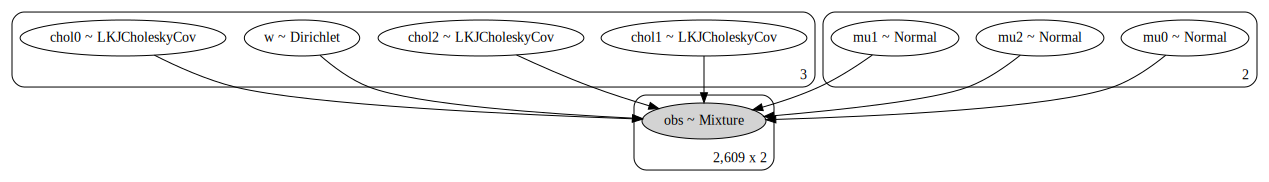

In [15]:
d = LoadData()
data_prior, m = d.prior_samples()
f = BayesianGMM(data_prior)
